In [1]:
import sys
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from redTools import *
from Kcorrect import *
from gamma_P1 import *

redTools.py:55: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  table   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py

<Figure size 1600x350 with 19 Axes>

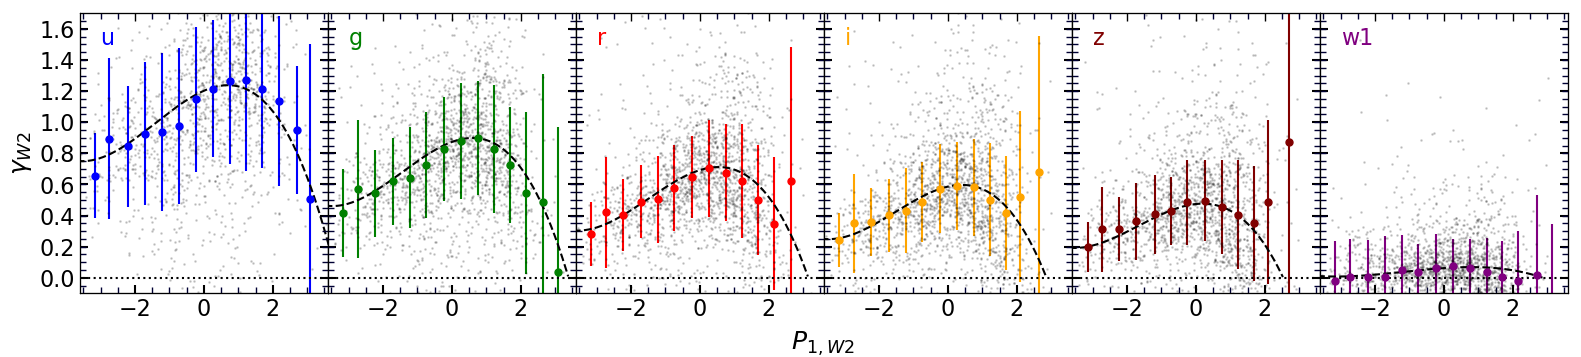

In [2]:
plot_array('ESN_HI_catal.csv', scatter=True, binned=True)

In [3]:
inFile = 'ESN_INC_P0_MAG.csv'
table = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)

pgc = table['pgc']
inc = table['inc']
pc0 = table['pc0']
u0   = table['u']
g0   = table['g']
r0   = table['r']
i0   = table['i']
z0   = table['z']
w1  = table['w1']
w2  = table['w2']
logWimx = table["logWimx"]
m21 = table["m21"]
mu50 = table["mu50"]
Wba = table["Wba"]
R50_w2 = table["R50_w2"]

u = u0-redCorrect(inc, pc0, band1='u', band2='w2')
g = g0-redCorrect(inc, pc0, band1='g', band2='w2')
r = r0-redCorrect(inc, pc0, band1='r', band2='w2')
i = i0-redCorrect(inc, pc0, band1='i', band2='w2')
z = z0-redCorrect(inc, pc0, band1='z', band2='w2')
w1 = w1-redCorrect(inc, pc0, band1='w1', band2='w2')

c21w = m21-w2

In [4]:
def gamma(band1='r', band2='w2'):
    
    r_w1 = table[band1]-table[band2]
    pc0 = table['pc0']
    a,b,c,d, alpha, beta, gamma, Ealpha, Ebeta = getReddening_params(band1=band1, band2=band2)
    q2 = 10**(-1.*gamma)
    F = log_a_b(inc, q2)
    R = r_w1 - (alpha*pc0+beta)
    R[np.where(R<0)]=0
    gama_lambda = R/F
    
    return gama_lambda

In [5]:
gamma_u = gamma(band1='u', band2='w2')
gamma_g = gamma(band1='g', band2='w2')
gamma_r = gamma(band1='r', band2='w2')
gamma_i = gamma(band1='i', band2='w2')
gamma_z = gamma(band1='z', band2='w2')
gamma_w1 = gamma(band1='w1', band2='w2')

indx = np.where(gamma_g>0)
gamma_u=gamma_u[indx]
gamma_g=gamma_g[indx]
gamma_r=gamma_r[indx]
gamma_i=gamma_i[indx]
gamma_z=gamma_z[indx]
gamma_w1=gamma_w1[indx]
pc0=pc0[indx]

indx = np.where(pc0>-3.5)
gamma_u=gamma_u[indx]
gamma_g=gamma_g[indx]
gamma_r=gamma_r[indx]
gamma_i=gamma_i[indx]
gamma_z=gamma_z[indx]
gamma_w1=gamma_w1[indx]
pc0=pc0[indx]

indx = np.where(pc0<2.5)
gamma_u=gamma_u[indx]
gamma_g=gamma_g[indx]
gamma_r=gamma_r[indx]
gamma_i=gamma_i[indx]
gamma_z=gamma_z[indx]
gamma_w1=gamma_w1[indx]
pc0=pc0[indx]

In [6]:
R_ug  = gamma_u/gamma_g
R_rg  = gamma_r/gamma_g
R_ig  = gamma_i/gamma_g
R_zg  = gamma_z/gamma_g
R_w1g = gamma_w1/gamma_g

R_ug  = R_ug[np.where(R_ug>0)]
R_rg  = R_rg[np.where(R_rg>0)]
R_ig  = R_ig[np.where(R_ig>0)]
R_zg  = R_zg[np.where(R_zg>0)]
R_w1g = R_w1g[np.where(R_w1g>0)]

pc0_ug  = pc0[np.where(R_ug>0)]
pc0_rg  = pc0[np.where(R_rg>0)]
pc0_ig  = pc0[np.where(R_ig>0)]
pc0_zg  = pc0[np.where(R_zg>0)]
pc0_w1g = pc0[np.where(R_w1g>0)]

In [7]:
from astropy.stats import sigma_clip
def sigclip(array):
    filtered_data = sigma_clip(array, sigma=3, iters=10, copy=False)
    clipped = filtered_data.data[np.logical_not(filtered_data.mask)]
    return np.median(clipped), clipped, np.logical_not(filtered_data.mask)

In [8]:
C_u, R_ug_, tu  =  sigclip(R_ug)
C_r, R_rg_, tr  =  sigclip(R_rg)
C_i, R_ig_, ti  =  sigclip(R_ig)
C_z, R_zg_, tz  =  sigclip(R_zg)
C_w1, R_w1g_, tw1 =  sigclip(R_w1g)

pc0_ur_ =  pc0_ug[np.where(tu == True)]
pc0_rg_ =  pc0_rg[np.where(tr == True)]
pc0_ir_ =  pc0_ig[np.where(ti == True)]
pc0_zr_ =  pc0_zg[np.where(tz == True)]
pc0_w1r_ =  pc0_w1g[np.where(tw1 == True)]

eC_u = np.std(R_ug_)
eC_r = np.std(R_rg_)
eC_i = np.std(R_ig_)
eC_z = np.std(R_zg_)
eC_w1 = np.std(R_w1g_)

In [19]:
################################################################# 
def add_axis(ax, xlim, ylim):
    
    x1, x2 = xlim[0], xlim[1]
    y1, y2 = ylim[0], ylim[1]
    ax.set_xlim(x1, x2)
    ax.set_ylim(y1, y2)

    ax.minorticks_on()
    ax.tick_params(which='major', length=7, width=1.5)
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0)     
    
    # additional Y-axis (on the right)
    y_ax = ax.twinx()
    y_ax.set_ylim(y1, y2)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=7, width=1.5, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

    # additional X-axis (on the top)
    x_ax = ax.twiny()
    x_ax.set_xlim(x1, x2)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=7, width=1.5, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
    
    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(12) 
    for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(12)    
                
########################################################### Begin

def plot_ratio(ax, pc0_ur, R_ur, C_u, eC_u, color='b', ylabel=r'$\gamma_u \/ / \/ \gamma_r$', xlim=(-3.1,3.1), ylim=(0,5)):

    ax.plot(pc0_ur, R_ur, 'o', color='black', markersize=1, alpha=0.20)                          
    ax.plot([-3,3],[C_u,C_u],'k--')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(r'$P_{1,W2}$', fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    add_axis(ax, xlim, ylim)
    
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = 0.9*Xlm[0]+0.1*Xlm[1]
    y0 = 0.2*Ylm[0]+0.8*Ylm[1]
    ax.text(x0,y0, '('+ylabel+')'+r'$_{av}$'+'='+'%.2f'%C_u+'$\pm$'+'%.2f'%eC_u, fontsize=12, color='k')
    
    low = -3; high=3
    for i in np.arange(low,high,0.5):
        x = []
        y = []
        for ii in range(len(R_ur)):
            xi = pc0_ur[ii]
            if xi>i and xi<=i+0.5:
                x.append(xi)
                y.append(R_ur[ii])
        if len(x)>0:

            x = np.asarray(x)
            y = np.asarray(y)

            average   = np.median(y)
            stdev = np.std(y)

            index = np.where(y<average+2.*stdev)
            x = x[index]
            y = y[index]

            index = np.where(y>average-2.*stdev)
            x = x[index]
            y = y[index]        

            ax.errorbar(np.median(x), np.median(y), yerr=np.std(y), fmt='o', color=color, markersize=5)

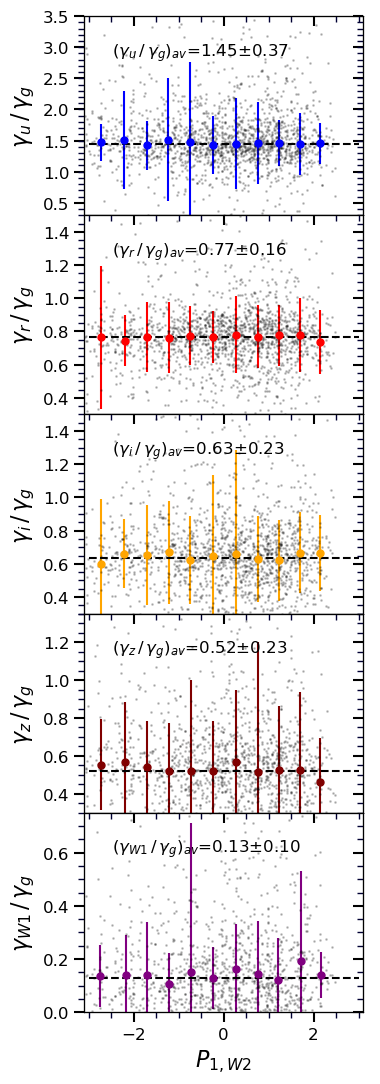

In [20]:
fig = py.figure(figsize=(3., 12), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.05, right=0.98)
gs = gridspec.GridSpec(5,1) ; p = 0

plt.subplots_adjust(hspace=.0, wspace=0)

ax = plt.subplot(gs[p]) ; p+=1
plot_ratio(ax, pc0_ug, R_ug, C_u, eC_u, color='b', ylabel=r'$\gamma_u \/ / \/ \gamma_g$', ylim=(0.3,3.5))

ax = plt.subplot(gs[p]) ; p+=1
plot_ratio(ax, pc0_rg, R_rg, C_r, eC_r, color='r', ylabel=r'$\gamma_r \/ / \/ \gamma_g$', ylim=(0.3,1.5))

ax = plt.subplot(gs[p]) ; p+=1
plot_ratio(ax, pc0_ig, R_ig, C_i, eC_i, color='orange', ylabel=r'$\gamma_i \/ / \/ \gamma_g$', ylim=(0.3,1.5))

ax = plt.subplot(gs[p]) ; p+=1
plot_ratio(ax, pc0_zg, R_zg, C_z, eC_z, color='maroon', ylabel=r'$\gamma_z \/ / \/ \gamma_g$', ylim=(0.3,1.35))

ax = plt.subplot(gs[p]) ; p+=1
plot_ratio(ax, pc0_w1g, R_w1g, C_w1, eC_w1, color='purple', ylabel=r'$\gamma_{W1} \/ / \/ \gamma_g$', ylim=(0,0.75))


fig.savefig("gamma_ratio.png")
fig.savefig("gamma_ratio.eps")

Text(0.5,0,'$\\lambda \\/\\/ [\\mu m]$')

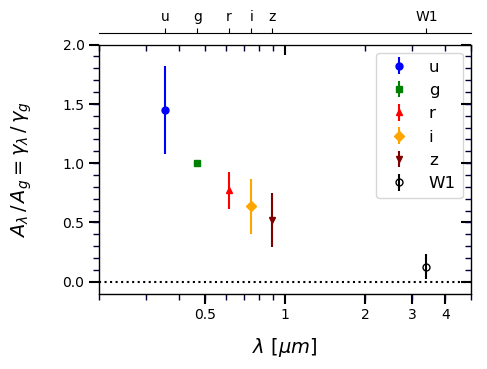

In [11]:
def plotMe(ax, gamma_lst, Egamma_lst):

    
    band1 = ['u','g','r','i','z','w1']
    
    C0 = 2.99792458     #  speed of light = C0*1.E8
    lambda_u = 0.3551  # https://classic.sdss.org/dr7/instruments/imager/index.html
    lambda_g = 0.4686  # micron
    lambda_r = 0.6165
    lambda_i = 0.7481
    lambda_z = 0.8931
    lambda_w1 = 3.4
    lambda_w2 = 4.6    
    wavelengths = [lambda_u, lambda_g, lambda_r, lambda_i, lambda_z, lambda_w1]
    
#     p1, = ax.plot(wavelengths[0], gamma_lst[0], 'bo',  markersize=6, label='u')
#     p2, = ax.plot(wavelengths[1], gamma_lst[1], 'gs',  markersize=6, label='g')
#     p3, = ax.plot(wavelengths[2], gamma_lst[2], 'r^',  markersize=6, label='r')
#     p4, = ax.plot(wavelengths[3], gamma_lst[3], 'D',  markersize=6, color='orange', label='i')
#     p5, = ax.plot(wavelengths[4], gamma_lst[4], 'v',  markersize=6, color='maroon', label='z')
#     p6, = ax.plot(wavelengths[5], gamma_lst[5], 'ko',  markersize=6, mfc='none', label='W1')
    
    p1 = ax.errorbar(wavelengths[0], gamma_lst[0], yerr=Egamma_lst[0], fmt='o', color='b', markersize=5, label='u')
    p2 = ax.errorbar(wavelengths[1], gamma_lst[1], yerr=Egamma_lst[1], fmt='s', color='g', markersize=5, label='g')
    p3 = ax.errorbar(wavelengths[2], gamma_lst[2], yerr=Egamma_lst[2], fmt='^', color='r', markersize=5, label='r')
    p4 = ax.errorbar(wavelengths[3], gamma_lst[3], yerr=Egamma_lst[3], fmt='D', color='orange', markersize=5, label='i')
    p5 = ax.errorbar(wavelengths[4], gamma_lst[4], yerr=Egamma_lst[4], fmt='v', color='maroon', markersize=5, label='z')
    p6 = ax.errorbar(wavelengths[5], gamma_lst[5], yerr=Egamma_lst[5], fmt='o', color='k', markersize=5, label='W1', mfc='none')

    ax.set_xlim(0.2,5)
    ax.set_xscale('log')
    ax.set_ylim(-0.1,2)    
    
    plt.xticks([0.5,1,2,3,4], ('0.5','1','2','3','4'))
    
    ax.plot([0.2,5],[0,0],'k:')

    ax.minorticks_on()
    ax.tick_params(which='major', length=7, width=1.5)
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0)    

    ## additional Y-axis (on the right)
    y_ax = ax.twinx()
    y_ax.set_ylim(-0.1,2)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=7, width=1.5, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
    
    ###additional X-axis (on the top)
    x_ax = ax.twiny()
    x_ax.set_xlim(0.2,5)
    x_ax.set_xscale('log')
    x_ax.set_xticklabels([])
    x_ax.tick_params(which='major', length=7, width=1.5, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
    
    ax.set_ylabel(r'$A_\lambda \/ / \/ A_g = \gamma_{\lambda} \/  / \/ \gamma_g$', fontsize=14, labelpad=20, rotation=90)
    
    if True:
        lns = [p1, p2, p3, p4, p5, p6]
        ### bbox_to_anchor=(x,y,width,height)
        ax.legend(handles=lns, fontsize=12, loc=0)
        
    if True:
        # Set scond x-axis
        ax2 = ax.twiny()
        ax2.set_xscale('log')
        ax2.set_xticks([])
        ax2.set_xticklabels([])
        ax2.minorticks_off()
        ax.minorticks_on()


        # Decide the ticklabel position in the new x-axis,
        # then convert them to the position in the old x-axis
        newlabel = ['u','g','r','i','z','W1']
        newpos   = wavelengths
        ax2.set_xticks(newpos)
        ax2.set_xticklabels(newlabel)
        
        ax2.xaxis.set_ticks_position('top') # set the position of the second x-axis to top
        ax2.xaxis.set_label_position('top') 
        ax2.spines['top'].set_position(('outward', 8))
        #ax2.set_xlabel('Band')
        ax2.set_xlim(ax.get_xlim())
        
    

fig = py.figure(figsize=(4,3), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)
plotMe(ax, [C_u, 1., C_r, C_i, C_z, C_w1], [eC_u, 0, eC_r, eC_i, eC_z, eC_w1])
ax.set_xlabel(r'$\lambda \/\/ [\mu m]$', fontsize=14, labelpad=10)

m:  [0.50284574]
Std Error m:  [0.03527442]


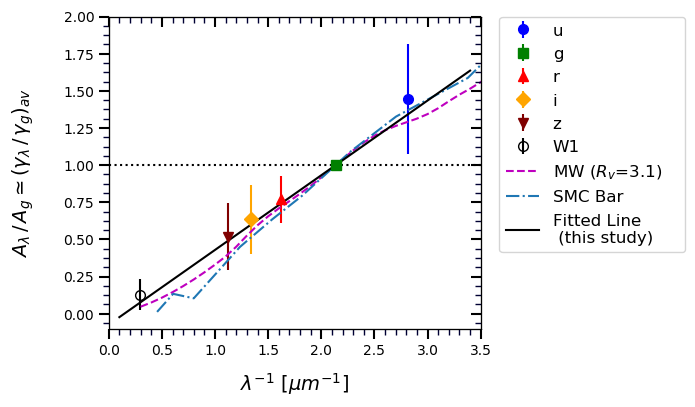

In [16]:
def Fa(x):
    if 5.9<= x <= 8:
        return -0.04473*(x-5.9)**2-0.009779*(x-5.9)**3
    else: return 0.
    
def Fb(x):
    if 5.9<= x <= 8:
        return 0.2130*(x-5.9)**2+0.1207*(x-5.9)**3
    else: return 0.    

def R_MW(x, Rv=3.1):
    
    if 0.3 <= x < 1.1:
        a = 0.574*x**1.61
        b = -0.527*x**1.61
    if 1.1 <= x < 3.3:
        y = x-1.82
        a = 1+0.17699*y-0.50447*y**2-0.02427*y**3+0.72085*y**4+0.01979*y**5-0.77530*y**6+0.32999*y**7
        b = 1.41338*y+2.28305*y**2+1.07233*y**3-5.38434*y**4-0.62251*y**5+5.30260*y**6-2.09002*y**7
    if 3.3 <= x <= 8:
        a = 1.752-0.316*x-0.104/((x-4.67)**2+0.341)+Fa(x)
        b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+Fb(x)
        
    return a+b/Rv
    
def plotMe2(ax, gamma_lst, Egamma_lst, p):

    
    band1 = ['u','g','r','i','z','w1']
    
    C0 = 2.99792458     #  speed of light = C0*1.E8
    lambda_u = 0.3551  # https://classic.sdss.org/dr7/instruments/imager/index.html
    lambda_g = 0.4686  # micron
    lambda_r = 0.6165
    lambda_i = 0.7481
    lambda_z = 0.8931
    lambda_w1 = 3.4
    lambda_w2 = 4.6    
    wavelengths = [lambda_u, lambda_g, lambda_r, lambda_i, lambda_z, lambda_w1]
    
#     p1, = ax.plot(1./wavelengths[0], gamma_lst[0], 'bo',  markersize=6, label='u')
#     p2, = ax.plot(1./wavelengths[1], gamma_lst[1], 'gs',  markersize=6, label='g')
#     p3, = ax.plot(1./wavelengths[2], gamma_lst[2], 'r^',  markersize=6, label='r')
#     p4, = ax.plot(1./wavelengths[3], gamma_lst[3], 'D',  markersize=6, color='orange', label='i')
#     p5, = ax.plot(1./wavelengths[4], gamma_lst[4], 'v',  markersize=6, color='maroon', label='z')
#     p6, = ax.plot(1./wavelengths[5], gamma_lst[5], 'ko',  markersize=6, mfc='none', label='W1')
    
    p1 = ax.errorbar(1./wavelengths[0], gamma_lst[0], yerr=Egamma_lst[0], fmt='o', color='b', markersize=7, mec='b', label='u')
    p2 = ax.errorbar(1./wavelengths[1], gamma_lst[1], yerr=Egamma_lst[1], fmt='s', color='g', markersize=7, mec='g', label='g')
    p3 = ax.errorbar(1./wavelengths[2], gamma_lst[2], yerr=Egamma_lst[2], fmt='^', color='r', markersize=7, mec='r', label='r')
    p4 = ax.errorbar(1./wavelengths[3], gamma_lst[3], yerr=Egamma_lst[3], fmt='D', color='orange', markersize=7, mec='orange', label='i')
    p5 = ax.errorbar(1./wavelengths[4], gamma_lst[4], yerr=Egamma_lst[4], fmt='v', color='maroon', markersize=7, mec='maroon', label='z')
    p6 = ax.errorbar(1./wavelengths[5], gamma_lst[5], yerr=Egamma_lst[5], fmt='o', color='k', markersize=7, label='W1', mec='k', mfc='none')
    
    
    ax.set_xlim(0,3.5)
    ax.set_ylim(-0.1,2)    
    
    ax.plot([0.,5],[1,1],'k:')

    ax.minorticks_on()
    ax.tick_params(which='major', length=7, width=1.5)
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0)    

    ## additional Y-axis (on the right)
    y_ax = ax.twinx()
    y_ax.set_ylim(-0.1,2)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=7, width=1.5, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
    
    ###additional X-axis (on the top)
    x_ax = ax.twiny()
    x_ax.set_xlim(0,3.5)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=7, width=1.5, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
    
    ax.set_ylabel(r'$A_\lambda \/ / \/ A_g \simeq (\gamma_{\lambda} \/  / \/ \gamma_g)_{av}$', fontsize=14, labelpad=20, rotation=90)
    
    if True:
        lns = [p1, p2, p3, p4, p5, p6]+p
        ### bbox_to_anchor=(x,y,width,height)
        ax.legend(handles=lns, fontsize=12, bbox_to_anchor=(1.05, 0, 0.5, 1), loc=2, borderaxespad=0., mode="expand")     
    


fig = py.figure(figsize=(4,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)



table   = np.genfromtxt('Gordon+03.csv' , delimiter=',', filling_values=np.nan, names=True, dtype=np.float64)

Lambda = table['lambda']
Xl = 1./Lambda
SMC = table['SMC_Bar']
LMC2 = table['LMC2']
LMC = table['LMC']

SMC_Rg_Rv = np.interp(1./0.4686, Xl, SMC)
LMC_Rg_Rv = np.interp(1./0.4686, Xl, LMC)
LMC[3] = np.interp(Xl[3]+0.00001, Xl, LMC)
LMC[4] = np.interp(Xl[4]+0.00001, Xl, LMC)
LMC2_Rg_Rv = np.interp(1./0.4686, Xl, LMC2)

Rg_Rv = R_MW(1./0.4686)
x = np.arange(0.3,8,0.1)
y = [R_MW(x0)/Rg_Rv for x0 in x]
y=np.asarray(y)

p = list()
pp, = ax.plot(x,y, 'm--', label='MW ('+r'$R_v$'+'=3.1)'); p+=[pp]
pp, = ax.plot(Xl, SMC/SMC_Rg_Rv, '-.', label='SMC Bar'); p+=[pp]
# pp, = ax.plot(Xl, LMC2/LMC_Rg_Rv, label='LMC Supershell'); p+=[pp]
# pp, = ax.plot(Xl, LMC/LMC2_Rg_Rv, 'mo', label='LMC Average'); p+=[pp]



##################### Fitted line
lambda_u = 0.3551  # https://classic.sdss.org/dr7/instruments/imager/index.html
lambda_g = 0.4686  # micron
lambda_r = 0.6165
lambda_i = 0.7481
lambda_z = 0.8931
lambda_w1 = 3.4
lambda_w2 = 4.6    
X  = np.asarray([1./lambda_u, 1./lambda_g, 1./lambda_r, 1./lambda_i, 1./lambda_z, 1./lambda_w1])
Y  = np.asarray([C_u, 1., C_r, C_i, C_z, C_w1])
eY = np.asarray([eC_u, 0, eC_r, eC_i, eC_z, eC_w1])

from scipy import odr
def myLine(m, x):
    x0=1./0.4686
    return m[0]*(x-x0)+1.
 
mydata = odr.Data(X, Y, wd=X*0., we=eY)
F = odr.Model(myLine)
myodr = odr.ODR(mydata, F, beta0=[1.])
myoutput = myodr.run()
m = myoutput.beta
print "m: ", m
print"Std Error m: ", myoutput.sd_beta
x = np.arange(0.1,3.5,0.1)
y = [myLine(m, x0) for x0 in x]
y=np.asarray(y)
pp1, = ax.plot(x,y, 'k-', label='Fitted Line \n (this study)')
p+=[pp1]
##################### Fitted line

plotMe2(ax, [C_u, 1., C_r, C_i, C_z, C_w1], [eC_u, 0, eC_r, eC_i, eC_z, eC_w1], p)
ax.set_xlabel(r'$\lambda^{-1} \/\/ [\mu m^{-1}]$', fontsize=14, labelpad=10)


fig.savefig("gamma_ratio_lambda.png")
fig.savefig("gamma_ratio_lambda.eps")



Text(0,0.5,'$A_\\lambda \\/ / \\/ A_g $')

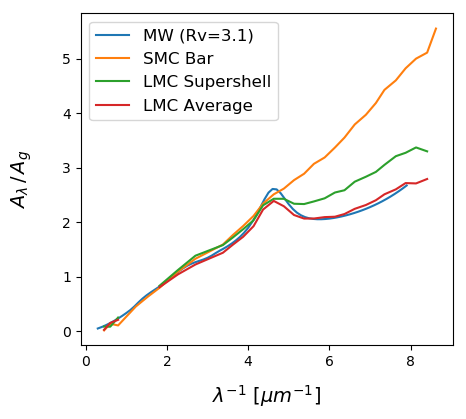

In [13]:
table   = np.genfromtxt('Gordon+03.csv' , delimiter=',', filling_values=np.nan, names=True, dtype=np.float64)

Lambda = table['lambda']
Xl = 1./Lambda
SMC = table['SMC_Bar']
LMC2 = table['LMC2']
LMC = table['LMC']

SMC_Rg_Rv = np.interp(1./0.4686, Xl, SMC)
LMC_Rg_Rv = np.interp(1./0.4686, Xl, LMC)
LMC2_Rg_Rv = np.interp(1./0.4686, Xl, LMC2)

Rg_Rv = R_MW(1./0.4686)
x = np.arange(0.3,8,0.1)
y = [R_MW(x0)/Rg_Rv for x0 in x]
y=np.asarray(y)

fig = py.figure(figsize=(4,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

p1, = ax.plot(x,y, label='MW (Rv=3.1)')
p2, = ax.plot(Xl, SMC/SMC_Rg_Rv, label='SMC Bar')
p3, = ax.plot(Xl, LMC2/LMC_Rg_Rv, label='LMC Supershell')
p4, = ax.plot(Xl, LMC/LMC2_Rg_Rv, label='LMC Average')


ax.legend(handles=[p1,p2,p3,p4], fontsize=12, loc=0)
ax.set_xlabel(r'$\lambda^{-1} \/\/ [\mu m^{-1}]$', fontsize=14, labelpad=10)
ax.set_ylabel(r'$A_\lambda \/ / \/ A_g $', fontsize=14, labelpad=20, rotation=90)